##### Exploration Data Analysis

In [ ]:
#Regression: Can you predict the rating of the drug based on the review?

#Check for the relations between datas

In [3]:
#Import the necessary libraries

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import randint

import nltk
import html
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from scipy.stats import spearmanr, pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMModel, LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
path='C:\\Users\\kurt_\\Dropbox\\code\\ulku\\Capstone2\\'
test=pd.read_csv(path+'data\\drugsComTest_raw.csv')
train=pd.read_csv(path+'data\\drugsComTrain_raw.csv')

merged = [train, test]
df = pd.concat(merged)

print (df.shape)
df.head()

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


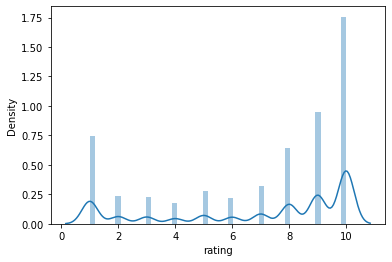

In [5]:
#Check 'rating' data: First, see value count ratios

sns.distplot(df['rating'])

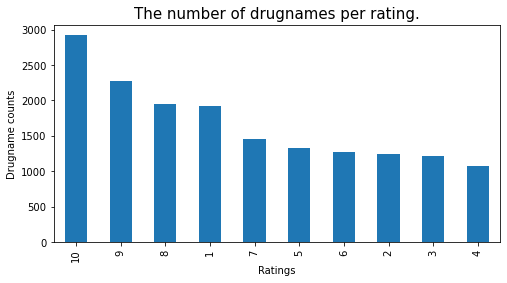

In [9]:
#Check for relation between rating and drugname
#We will see the most used ratings for the drugs: 1, 8, 9, 10.

rat_drug = df.groupby(['rating'])['drugName'].nunique().sort_values(ascending=False)
rat_drug.plot(kind="bar", figsize=(8, 4))
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Drugname counts", fontsize = 10)
plt.title("The number of drugnames per rating.", fontsize = 15)
plt.show()
plt.close()

In [10]:
#Check for mean and count of rating for drug names

df.groupby(['drugName'])['rating'].agg(['count', 'mean']).sort_values(by=['count', 'mean'], ascending=False)[:10]

,count,mean
drugName,,
Levonorgestrel,4930,7.384584
Etonogestrel,4421,5.824022
Ethinyl estradiol / norethindrone,3753,5.589129
Nexplanon,2892,5.643154
Ethinyl estradiol / norgestimate,2790,5.802151
Ethinyl estradiol / levonorgestrel,2503,5.763084
Phentermine,2085,8.776978
Sertraline,1868,7.452891
Escitalopram,1747,7.829422


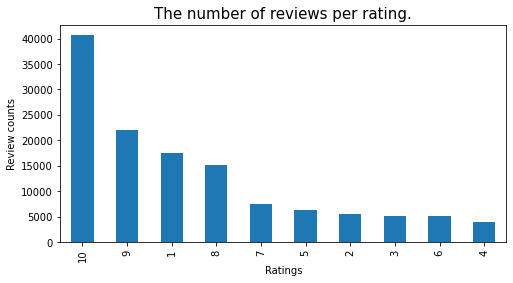

In [11]:
#Check for relation between rating and reviews
#We will see the highest reviewed ratings 1, 8, 9, 10.

rat_rev = df.groupby(['rating'])['review'].nunique().sort_values(ascending=False)
rat_rev.plot(kind="bar", figsize=(8, 4))
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Review counts", fontsize = 10)
plt.title("The number of reviews per rating.", fontsize = 15)
plt.show()
plt.close()

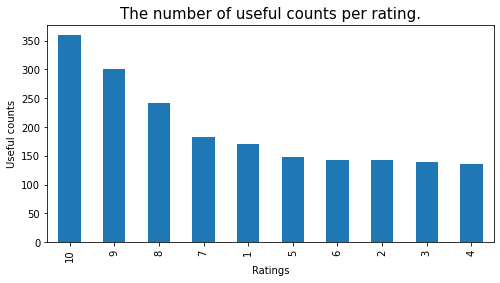

In [12]:
#Check for relation between usefulcounts and ratings.
#We will see the most used ratings for usefulcounts: 1, 7, 8, 9, 10.

rat_use = df.groupby(['rating'])['usefulCount'].nunique().sort_values(ascending=False)
rat_use.plot(kind="bar", figsize=(8, 4))
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Useful counts", fontsize = 10)
plt.title("The number of useful counts per rating.", fontsize = 15)
plt.show()
plt.close()

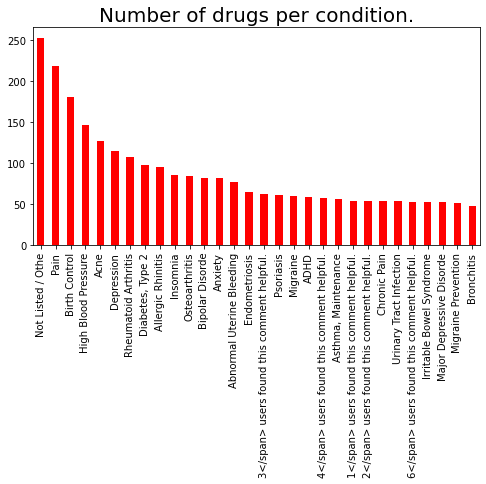

In [13]:
#Check for condition
#We will see the top 30 condition has at least 50 drugs to apply.

con_drug = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
con_drug[0:30].plot(kind="bar", figsize = (8, 4), fontsize = 10, color="red")
plt.xlabel("", fontsize = 13)
plt.ylabel("", fontsize = 13)
plt.title("Number of drugs per condition.", fontsize = 20)
plt.show()

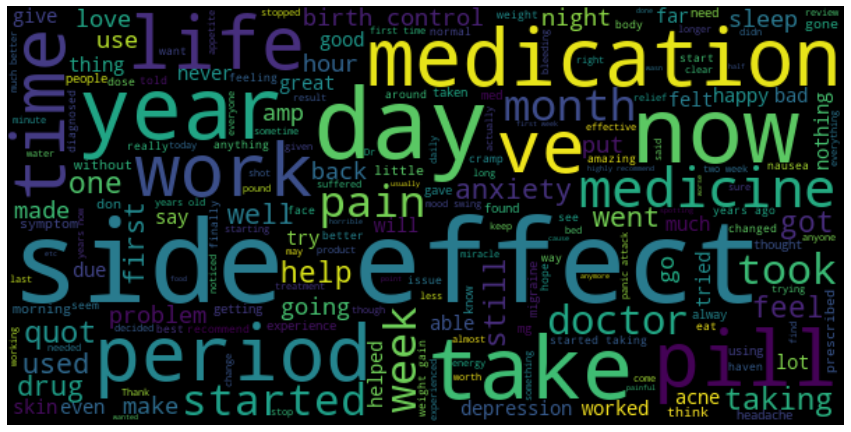

In [14]:
#Check for a review which has rating 10.

best_review = df.loc[train.rating == 10, 'review']
k = (' '.join(best_review))

wordcloud = WordCloud(width = 600, height = 300, background_color = 'black').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

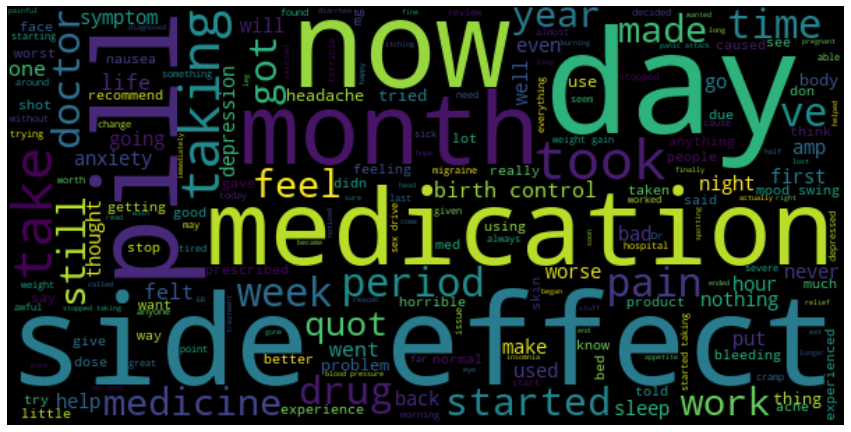

In [15]:
#Check for a review which has rating 1.

worst_review = df.loc[train.rating == 1, 'review']
k2 = (' '.join(worst_review))

wordcloud = WordCloud(width = 600, height = 300, background_color = 'black').generate(k2)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

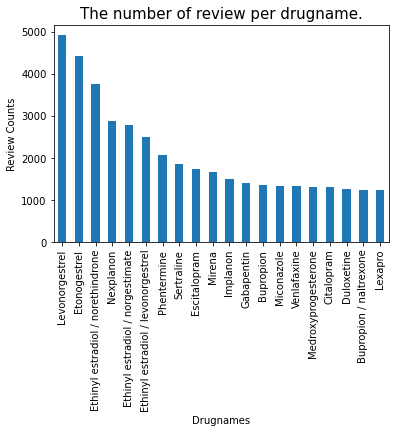

In [16]:
#Let's see the relation between drugnames and reviews
#We will see the top 20 drugs which have minimum 1000 reviews

drug_rev = df.groupby(['drugName'])['review'].nunique().sort_values(ascending=False)
drug_rev[0:20].plot(kind="bar", figsize=(6, 4))
plt.xlabel("Drugnames", fontsize = 10)
plt.ylabel("Review Counts", fontsize = 10)
plt.title("The number of review per drugname.", fontsize = 15)
plt.show()

Sentiment analysis for reviews:

All named and numeric character references (e.g. &gt,  &#62;,  &#x3e;) in the string will be converted to the corresponding Unicode characters.

In [18]:
def convert_reviews(review):
    return html.unescape(review) 

print("Review: ", df.loc[0, 'review'])

df['review'] = df['review'].apply(convert_reviews) 

df.head(2) 

Review:  0    "It has no side effect, I take it in combinati...
0    "I've tried a few antidepressants over the yea...
Name: review, dtype: object


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192


In [19]:
#Apply sentiment analyze to review

sia = SentimentIntensityAnalyzer() 
df["sentiment"] = df["review"].apply(lambda x: sia.polarity_scores(x)["compound"])

The probability of the sentiment is positive : compound score>=0.05

The probability of the sentiment is neutral : compound score between -0.05 and 0.05

The probability of the sentiment is negative : compound score<=-0.05

compound: The normalized compound score which calculates the sum of all lexicon ratings and takes values from -1 to 1

In [20]:
#Check for Vader effect on some reviews

df.loc[[4, 75, 157, 254, 578, 1289, 4899, 98543, 160000], ["review", "rating", "sentiment"]]

,review,rating,sentiment
4,"""Suboxone has completely turned my life around...",9,0.9403
4,"""I have been on this birth control for one cyc...",9,0.9559
75,"""I've had mine for over a year and noticed the...",6,0.7777
75,"""Pregabalin for me was miraculous. On the firs...",10,0.8809
157,"""I got this inserted 3 years ago, my arm hurt ...",9,-0.4215
157,"""I switched to Gianvi from Aviane in hopes of ...",4,-0.0545
254,"""My Dr agreed to over see putting me on Qsymia...",9,0.7033
254,"""On day 17 of 25 day Efudex fluorouracil 5% cr...",10,0.1842
578,"""This medication completely changed my life fo...",10,-0.7224
578,"""I have been on various medications for years,...",10,0.9711


In [21]:
#Check for correlation between rating and sentiment
#We will see a moderate correlation between rating and sentiment

spearmanr(df['sentiment'], df['rating'])

SpearmanrResult(correlation=0.31625065239783867, pvalue=0.0)

Pearson correlation coefficient (0.4926998142432388, 7.989948920372318e-57)


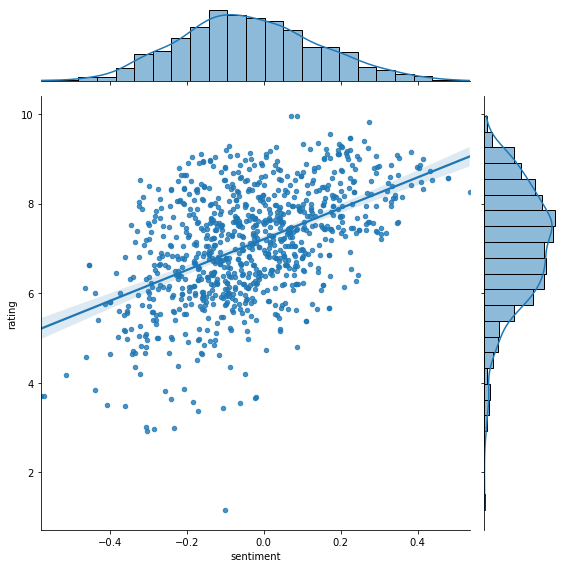

In [22]:
# Check for Vader performs on the average ratings in the most reviewed drugs 
# We will use 75% quantile, to see the most reviewed drugs

group1 = df.groupby(["drugName"]).agg({"uniqueID": pd.Series.nunique})
group2 = df.groupby(["drugName"])
group2 = group2.agg({
    'sentiment': np.mean,  
    'rating': np.mean,  
    'uniqueID': pd.Series.nunique})

group2 = group2[group2["uniqueID"] > group1.quantile(q=0.75)[0]]

plot = sns.jointplot(x="sentiment", y="rating", data=group2, kind="reg", height=8, scatter_kws={"s": 20})

print("Pearson correlation coefficient", pearsonr(group2['sentiment'], group2['rating']))

In [24]:
#Pre-processing for taking confidence interval from mean of rating and sentiment

def sampling(dt, n=50):
    return np.random.choice(dt, n)
def sampling_dist(dt, k, n=50):
    samples = []
    for i in range(k):
        samples.append(np.mean(sampling(dt, n)))
    return pd.Series(samples)
def plot_stat(dt):
    mean = np.mean(dt)
    std = np.std(dt, ddof=1)
    median = np.median(dt)
    plt.style.use('ggplot')
    _ = plt.hist(dt,bins=20, density = True )
    _ = plt.axvline(mean, c='b', linestyle='--', label='mean', alpha=0.3)
    _ = plt.axvline(median,c='black', linestyle='--', label='median', alpha=0.3)
    _ = plt.legend()
    # _ = plt.annotate('mean',(mean_chrg,))
    # _ = plt.annotate('median',(median_chrg*0.15,2e-5))
    return mean, std, median

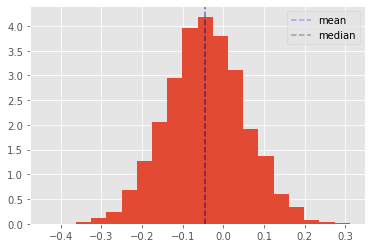

In [25]:
#We will see the mean of sentiment is neutral

sentiment_sample_dist = sampling_dist(df.sentiment, 10000)
_mean, _std, _median = plot_stat(sentiment_sample_dist)

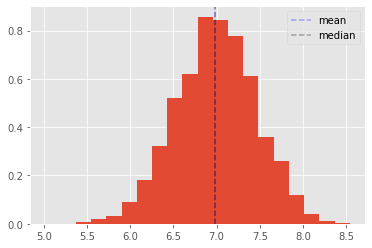

In [26]:
#We will see the mean of rating is 7

rating_sample_dist = sampling_dist(df.rating, 10000)
_mean, _std, _median = plot_stat(rating_sample_dist)

According to the sentiment_sample_dist graph, the sentiment mean is neutral. And, according to the rating_sample_dist graph, the rating mean is 7. We will use this knowledge in the next steps.  

In [27]:
#Check for confidence interval for rating

size = len(rating_sample_dist)
sample = np.random.choice(a = rating_sample_dist, size=size)
sample_mean = sample.mean()

z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*

print("z-critical value:")              # Check the z-critical value
print(z_critical)                        

pop_stdev = rating_sample_dist.std()  # Get the population standard deviation

margin_of_error = z_critical * (pop_stdev/math.sqrt(size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval)
print(sample_mean)

z-critical value:
1.959963984540054
Confidence interval:
(6.977066411358627, 6.995241588641375)
6.986154000000001


In [29]:
#Check for confidence interval for sentiment

size=len(sentiment_sample_dist)
sample = np.random.choice(a= sentiment_sample_dist, size=size)
sample_mean = sample.mean()

z_critical = stats.norm.ppf(q = 0.975)  

print("z-critical value:")              
print(z_critical)                        

pop_stdev = sentiment_sample_dist.std()  

margin_of_error = z_critical * (pop_stdev/math.sqrt(size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval)
print(sample_mean)

z-critical value:
1.959963984540054
Confidence interval:
(-0.04466351408328091, -0.04090106431671908)
-0.0427822892


##### Pre-Processing

In [30]:
#We will seperate ratings 2 group to make classification work better, based on rating_sample_dist 
#and sentiment_sample_dist.

#rating>7 will be assigned 1
#rating<=7 will be assigned 0

df['new_sentiment'] = df['rating'].apply(lambda x: 1 if x > 7 else 0)

df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,new_sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,-0.2960,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,0.8603,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0.7645,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,0.7184,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,0.9403,1


Steps for reviews pre-processing

1. Remove HTML tags
2. Remove Stop Words
3. Remove symbols and special characters
4. Tokenize
5. Stemming

In [31]:
stops = set(stopwords.words('english')) 

stemmer = SnowballStemmer('english')

def clean_review(text):
     
    review_text = BeautifulSoup(text, 'html.parser').get_text()
    
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    
    words = letters_only.lower().split()
    
    meaningful_words = [w for w in words if not w in stops]
    
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    return( ' '.join(stemming_words))

In [32]:
#Apply clean_review() function on review for df

df['review'] = df['review'].apply(clean_review)

We will predict the new_sentiment by using the reviews only.

First, we have to convert the review to numeric values by using TF IDF Vectorizer. The TF counts how many times a word has repeated in a given corpus. Since a corpus is occured by many documents, each documents and its words will have their own TF count. As for IDF, it counts how rarely a word occurs in a document. 

In [65]:
#Represent the review as a bag-of-words 

bow_transform = CountVectorizer()
Xbow = bow_transform.fit_transform(df['review'])

#Create the tf-idf by using the bag-of-words matrix

tfidf_trf = TfidfTransformer(norm=None)
Xtfidf = tfidf_trf.fit_transform(Xbow)

#Normalize the bag-of-words representation

Xnorm = preprocessing.normalize(Xbow, axis=0)

##### Modeling

In [78]:
#Split the data as train and test set

X = Xnorm

y = df.new_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print('Train data shape ', X_train.shape)
print('Test data shape ', X_test.shape)

Train data shape  (150544, 34830)
Test data shape  (64519, 34830)


##### Apply the first model: LightGBM 

In [84]:
def pipeline_(Xtrain, Xtest, ytrain, ytest, 
                       model, param_grid, cv = 10, scoring_fit = 'neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator = model,
        param_grid = param_grid,
        cv = cv,
        n_jobs = -1, 
        scoring = scoring_fit
    )
    fitted_model = gs.fit(Xtrain, ytrain)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(Xtest)
    else:
      pred = fitted_model.predict(Xtest)
    
    return fitted_model, pred

In [41]:
model = lgb.LGBMClassifier()

param_grid = {
    'n_estimators': [10000],
    'max_depth': [10],
    'learning_rate' : [0.1],
    'num_leaves' : [30],
    'lambda_l1': [0.5], 
    'lambda_l2': [0.5],
    'max_bin': [1000]
}

model, pred = pipeline_(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv = 10, scoring_fit = 'accuracy')

print(model.best_score_)
print(model.best_params_)
print("Accuracy score is {}".format(accuracy_score(model.predict(X_test), y_test)))

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
0.8909288973070135
{'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.1, 'max_bin': 1000, 'max_depth': 10, 'n_estimators': 10000, 'num_leaves': 30}
Accuracy score is 0.8985415149025868


##### Apply the second model: RandomForest

In [85]:
model1 = RandomForestClassifier()

param_grid = {
    'n_estimators': [100],
    'max_depth': [10000],
    'min_samples_split' : [0.001]
}

model1, pred = pipeline_(X_train, X_test, y_train, y_test, model1, 
                                 param_grid, cv=5, scoring_fit='accuracy')

# Evaluates model on test set

pred = model1.predict(X_test)

print("Accuracy: %s" % str(model1.score(X_test, y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test))

Accuracy: 0.8315844944899952
Confusion Matrix
[[16386  1477]
 [ 9389 37267]]


##### Apply the third model: Logistic Regression

In [87]:
# Setup the hyperparameter grid

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg

logreg = LogisticRegression(class_weight='auto', max_iter=10000)

# Instantiate the GridSearchCV object: logreg_cv

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data

logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

print("Best score is {}".format(logreg_cv.best_score_))

print("Accuracy score is {}".format(accuracy_score(logreg_cv.predict(X_test), y_test)))

Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
Best score is 0.8032800972815466
Accuracy score is 0.8099474573381484


##### Conclusion

According to the three models, LightGBM is the one we can get the best results. 